# 📊 Projeto de Previsão de Churn - Telecom
**Disciplina:** Redes Neurais | **Aluno:** Douglas Carvalho

---

### 🎯 Objetivo
Desenvolver e avaliar um classificador baseado em **Tabular Kolmogorov-Arnold Networks (TabKAN)**, uma arquitetura inovadora que substitui MLPs tradicionais por funções de ativação aprendíveis nas arestas.

### 🛠 Metodologia
Seguindo as diretrizes do projeto, a abordagem consiste em:
1.  **Setup do Ambiente:** Configuração e carregamento dos dados processados.
2.  **Modelagem TabKAN:** Treinamento da rede KAN adaptada para dados tabulares.
3.  **Avaliação:** Métricas completas (KS, AUROC, F1) e validação de estabilidade.
4.  **Registro:** Salvamento automático de logs, artefatos e dashboard.

# ==========================================
# 0. Imports & Instalação
# ==========================================

In [1]:
%%capture
!pip install -q xgboost pykan

import sys
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import kagglehub
import shutil

# Configuração de Plots
plt.style.use('seaborn-v0_8-whitegrid')

# ==========================================
# 1. Setup do Ambiente
# ==========================================

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# ==========================================
Adicionar diretório atual ao path para importações funcionarem
# ==========================================

In [3]:
import sys
import os

sys.path.append('.')

# ==========================================
Correção para Auto-Reload no Python 3.12 (Google Colab)
# ==========================================

In [4]:
import importlib

if 'imp' not in sys.modules:
    sys.modules['imp'] = importlib

%load_ext autoreload
%autoreload 2

# ==========================================
# 2. Github
# ==========================================

In [5]:
# Clonar repositório (se não estiver rodando local)
!git clone https://github.com/vggd18/telecom-churn-project.git
%cd telecom-churn-project
!git checkout feature/tabpfn-stab-tabkan_final

Cloning into 'telecom-churn-project'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 306 (delta 41), reused 65 (delta 22), pack-reused 206 (from 1)
Receiving objects: 100% (306/306), 8.39 MiB | 18.27 MiB/s, done.
Resolving deltas: 100% (112/112), done.
/content/telecom-churn-project
Branch 'feature/tabpfn-stab-tabkan_final' set up to track remote branch 'feature/tabpfn-stab-tabkan_final' from 'origin'.
Switched to a new branch 'feature/tabpfn-stab-tabkan_final'


In [7]:

# 1. Baixa as informações mais recentes do GitHub (sem tentar mesclar ainda)
!git fetch --all

# 2. Reseta o estado atual do Colab para ficar IDÊNTICO ao do GitHub
# !git reset --hard origin/feature/tabpfn-stab-tabkan_final

Fetching origin


# ==========================================
Importar as ferramentas para resultados
# ==========================================

In [8]:
from src.utils import ensure_directories, get_timestamped_path, log_experiment

ensure_directories()
print("✅ Diretórios de resultados verificados/criados.")

✅ Diretórios de resultados verificados/criados.


# ==========================================
# 3. Dados
# ==========================================

In [9]:
print("⬇️ Baixando dataset do Kaggle...")
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")

print(f"📂 Dataset baixado em: {path}")
dest_dir = "data/raw"
dest_file = "telecom_churn.csv"

dest_path = os.path.join(dest_dir, dest_file)

os.makedirs(dest_dir, exist_ok=True)

source_file = os.path.join(path, "customer_churn_telecom_services.csv")

if os.path.exists(source_file):
    shutil.copy(source_file, dest_path)
    print(f"✅ Arquivo movido com sucesso para: {dest_path}")
else:
    print(f"⚠️ Arquivo não encontrado em {source_file}. Verifique o conteúdo da pasta baixada.")
    print(os.listdir(path))

⬇️ Baixando dataset do Kaggle...


100%|██████████| 112k/112k [00:00<00:00, 18.1MB/s]

📂 Dataset baixado em: /root/.cache/kagglehub/datasets/kapturovalexander/customers-churned-in-telecom-services/versions/3
✅ Arquivo movido com sucesso para: data/raw/telecom_churn.csv


# ==========================================
Executar Pipeline de Dados
# ==========================================

In [10]:
!python scripts/prepare_data.py

🚀 PIPELINE DE PREPROCESSAMENTO (seguindo PDF)

📂 1. Carregando dados...
   Shape original: (7043, 20)
   Missing values: 11
   ⚠️  Removendo linhas com missing
   Shape após limpeza: (7032, 20)
   ✓ Churn convertido para 0/1
   Distribuição Churn: {0: 5163, 1: 1869}

✂️ 2. Particionamento (50/25/25)...
   Classe 0 (No Churn): 5163
   Classe 1 (Churn): 1869

   Split Classe 0:
      Train: 2581
      Val: 1290
      Test: 1292

   Split Classe 1:
      Train: 934
      Val: 467
      Test: 468
   ✅ Verificação: Sem overlap entre splits

   Conjuntos (ANTES do balanceamento):
      Train: (3515, 20) - Dist: {0: 2581, 1: 934}
      Val: (1757, 20) - Dist: {0: 1290, 1: 467}
      Test: (1760, 20) - Dist: {0: 1292, 1: 468}

📏 4. Pré-processamento (encoding + normalização)...
   Numéricas: 4 colunas
   Categóricas: 15 colunas
   Aplicando transformações...
   ✓ Train processado: (3515, 30)
   ✓ Val processado: (1757, 30)
   ✓ Test processado: (1760, 30)

   Validação da normalização:
      T

In [11]:

from models.tabkan_model import TabKANModel
from src.metrics import calculate_all_metrics
from src.visualization import plot_ks_statistic, plot_roc_curve, plot_confusion_matrix

DATA_DIR = 'data/processed'

X_train = np.load(f'{DATA_DIR}/X_train.npy')
y_train = np.load(f'{DATA_DIR}/y_train.npy')
X_val = np.load(f'{DATA_DIR}/X_val.npy')
y_val = np.load(f'{DATA_DIR}/y_val.npy')
X_test = np.load(f'{DATA_DIR}/X_test.npy')
y_test = np.load(f'{DATA_DIR}/y_test.npy')

print(f"✅ Dados carregados!")
print(f"Train: {X_train.shape} (Balanceado)")
print(f"Val:   {X_val.shape} (Balanceado)")
print(f"Test:  {X_test.shape} (Desbalanceado/Real)")

def print_metrics(dataset_name, metrics):
    print(f"--- {dataset_name} ---")
    print(f"KS:        {metrics['ks']:.4f} (Threshold: {metrics['ks_threshold']:.2f})")
    print(f"AUROC:     {metrics['auroc']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")

✅ Dados carregados!
Train: (5162, 30) (Balanceado)
Val:   (2580, 30) (Balanceado)
Test:  (1760, 30) (Desbalanceado/Real)


# ==========================================
# 5. Experimento: TabKANModel (PyTorch) com hiperparâmetros
# ==========================================

🚀 Treinando TabKANModel (tuned + debug)...
========== TabKAN INIT ==========
Device: cpu
Config efetivo:
 depth=2 hidden_dim=32 grid_size=12 x_range=[-3.0,3.0]
 activation=relu dropout=0.1
 lr=0.001 weight_decay=0.0
 batch_size=256 epochs=30 max_fail=8

[build] input_dim registrado = 30
========== TRAIN START ==========
epochs=30, batch_size=256, max_fail=8
n_train=5162, n_val=2580, num_batches/epoch=21

[epoch 1/30] train_loss=0.683195 val_loss=0.658757 time=0.7s
[epoch 2/30] train_loss=0.630660 val_loss=0.581159 time=0.8s
[epoch 3/30] train_loss=0.556521 val_loss=0.519414 time=0.4s
[epoch 4/30] train_loss=0.504363 val_loss=0.498955 time=0.3s
[epoch 5/30] train_loss=0.490327 val_loss=0.494092 time=0.3s
[epoch 6/30] train_loss=0.484492 val_loss=0.490591 time=0.3s
[epoch 7/30] train_loss=0.480047 val_loss=0.489105 time=0.3s
[epoch 8/30] train_loss=0.478470 val_loss=0.485788 time=0.3s
[epoch 9/30] train_loss=0.469426 val_loss=0.485918 time=0.3s
[epoch 10/30] train_loss=0.468246 val_loss=

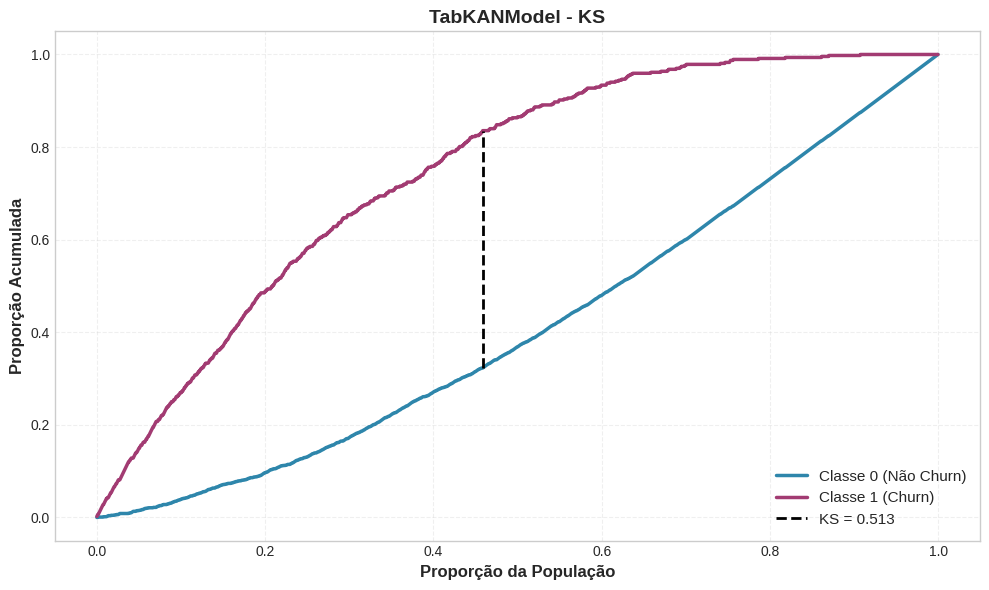

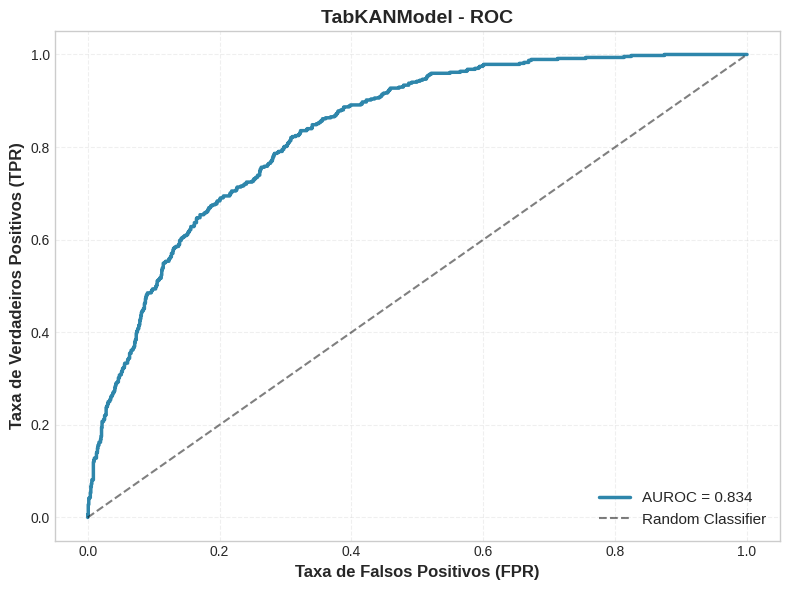

In [12]:
print("🚀 Treinando TabKANModel (tuned + debug)...")

tabkan_config = {
    "depth": 2,
    "hidden_dim": 32,
    "grid_size": 12,
    "activation": "relu",
    "dropout": 0.1,
    "lr": 1e-3,
    "weight_decay": 0.0,
    "batch_size": 256,
    "epochs": 30,
    "max_fail": 8,
    "verbose": True

}

# Instancia modelo
tabkan = TabKANModel(config=tabkan_config)

# Build com input_dim
tabkan.build(input_dim=X_train.shape[1])

# Treino
tabkan.train(X_train, y_train, X_val, y_val)

# Avaliação no Teste
y_pred_tabkan = tabkan.predict_proba(X_test)
metrics_tabkan = calculate_all_metrics(y_test, y_pred_tabkan)

print_metrics("TabKANModel (Teste)", metrics_tabkan)
plot_ks_statistic(y_test, y_pred_tabkan, title="TabKANModel - KS")
plot_roc_curve(y_test, y_pred_tabkan, title="TabKANModel - ROC")


📊 Calculando métricas finais...

🏆 RESULTADOS FINAIS (Teste):
   KS:       0.5127
   AUROC:    0.8342
   F1 Score: 0.6117
📊 Dashboard salvo em: results/figures/dashboard_final_tabkan_20260110_204728.png


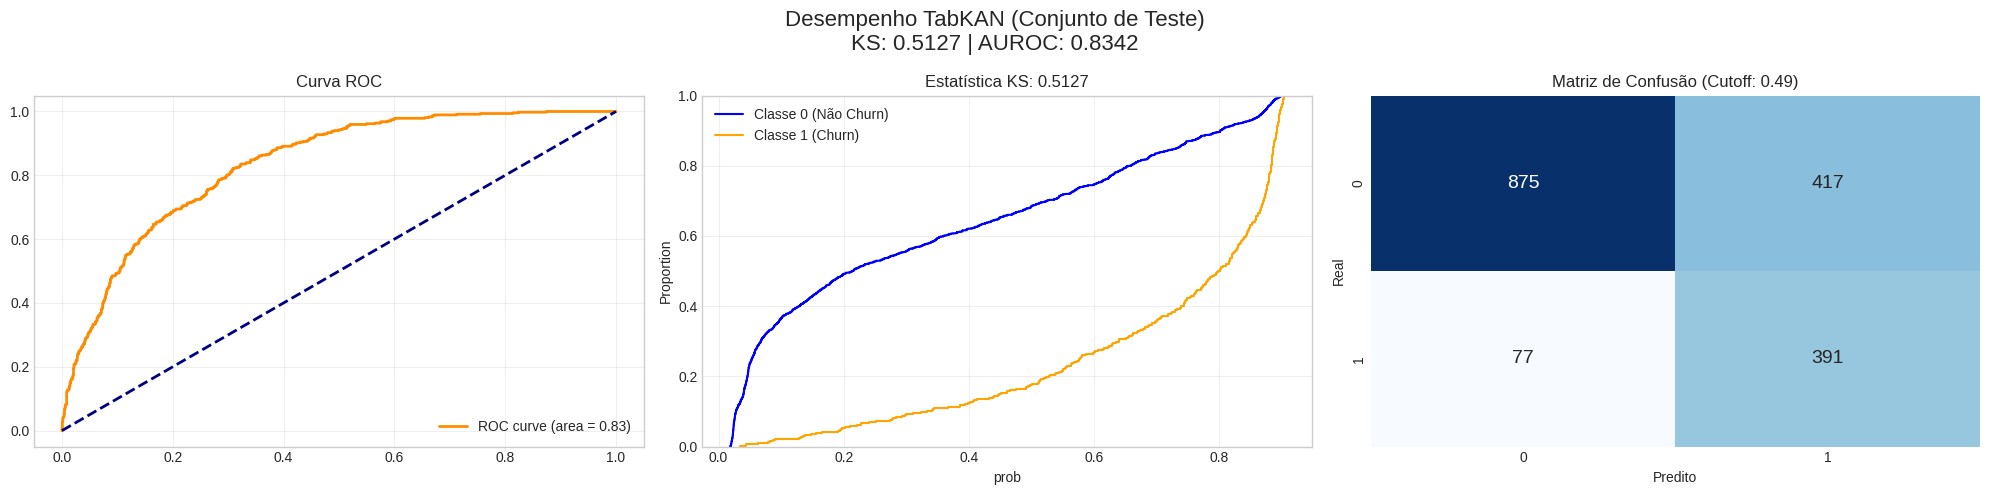

📈 Gráfico KS salvo em: results/figures/tabkan_ks_20260110_204729.png
📈 Curva ROC salva em: results/figures/tabkan_roc_20260110_204730.png
📝 Metadados (JSON) salvos em: results/metrics/tabkan_meta_20260110_204730.json
💾 Modelo salvo (via joblib): results/models/tabkan_model_final_20260110_204730.pth
💾 Modelo salvo em: results/models/tabkan_model_final_20260110_204730.pth
✅ Experimento registrado no CSV log.


In [13]:
import json
import torch
import joblib
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ==============================================================================
# 5. Avaliação e Salvamento Padronizado
# ==============================================================================

# 1. Previsão e Métricas
# ---------------------------------------------------------
print("📊 Calculando métricas finais...")
y_pred_tabkan = tabkan.predict_proba(X_test)

# Garante array 1D
if y_pred_tabkan.ndim > 1 and y_pred_tabkan.shape[1] > 1:
    y_pred_tabkan = y_pred_tabkan[:, 1]

metrics_tabkan = calculate_all_metrics(y_test, y_pred_tabkan)

print(f"\n🏆 RESULTADOS FINAIS (Teste):")
print(f"   KS:       {metrics_tabkan['ks']:.4f}")
print(f"   AUROC:    {metrics_tabkan['auroc']:.4f}")
print(f"   F1 Score: {metrics_tabkan['f1']:.4f}")


# 2. Gerar e Salvar Dashboard (Visual Único)
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle(f'Desempenho TabKAN (Conjunto de Teste)\nKS: {metrics_tabkan["ks"]:.4f} | AUROC: {metrics_tabkan["auroc"]:.4f}', fontsize=16)

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_tabkan)
roc_auc = auc(fpr, tpr)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Curva ROC')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Curva KS
data_plot = pd.DataFrame({'prob': y_pred_tabkan, 'target': y_test})
sns.ecdfplot(data=data_plot[data_plot.target==0], x='prob', ax=axes[1], label='Classe 0 (Não Churn)', color='blue')
sns.ecdfplot(data=data_plot[data_plot.target==1], x='prob', ax=axes[1], label='Classe 1 (Churn)', color='orange')
axes[1].set_title(f'Estatística KS: {metrics_tabkan["ks"]:.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Matriz de Confusão
y_pred_class = (y_pred_tabkan >= metrics_tabkan.get('ks_threshold', 0.5)).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2], cbar=False, annot_kws={"size": 14})
axes[2].set_title(f'Matriz de Confusão (Cutoff: {metrics_tabkan.get("ks_threshold", 0.5):.2f})')
axes[2].set_xlabel('Predito')
axes[2].set_ylabel('Real')

plt.tight_layout()
dashboard_path = get_timestamped_path("dashboard_final_tabkan.png", subfolder="figures")
plt.savefig(dashboard_path)
print(f"📊 Dashboard salvo em: {dashboard_path}")
plt.show()


# 3. Salvar Gráficos Individuais
# ---------------------------------------------------------
ks_path = get_timestamped_path("tabkan_ks.png", subfolder="figures")
plot_ks_statistic(
    y_test,
    y_pred_tabkan,
    title="TabKAN Model - KS",
    output_path=ks_path
)

roc_path = get_timestamped_path("tabkan_roc.png", subfolder="figures")
plot_roc_curve(
    y_test,
    y_pred_tabkan,
    title="TabKAN Model - ROC",
    output_path=roc_path
)


# 4. Salvar Modelo e Metadados
# ---------------------------------------------------------

# A. Metadados (JSON)
meta_data = {
    "model": "TabKANModel",
    "config": tabkan_config,
    "metrics": metrics_tabkan
}
meta_path = get_timestamped_path("tabkan_meta.json", subfolder="metrics")
with open(meta_path, 'w') as f:
    json.dump(meta_data, f, indent=4)
print(f"📝 Metadados (JSON) salvos em: {meta_path}")

# B. Modelo (PKL/PTH)
model_path = get_timestamped_path("tabkan_model_final.pth", subfolder="models")
try:
    if hasattr(tabkan, 'save'):
        tabkan.save(model_path)
    else:
        try:
            torch.save(tabkan.state_dict(), model_path)
        except:
            joblib.dump(tabkan, model_path.replace('.pth', '.pkl'))
    print(f"💾 Modelo salvo em: {model_path}")
except Exception as e:
    print(f"⚠️ Erro ao salvar modelo: {e}")


# 5. Registrar no Log Geral
# ---------------------------------------------------------
log_experiment(
    log_file='results/experiments_log.csv',
    model_name='TabKAN_Standard',
    metrics=metrics_tabkan,
    params=tabkan_config
)
print("✅ Experimento registrado no CSV log.")

# ==========================================
# 2. Salvar Resultados
# ==========================================

In [15]:
import shutil
from google.colab import files

output_filename = 'results.zip'

folder_to_zip = 'results'

shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_to_zip)

files.download(output_filename)

print(f"✅ Pasta '{folder_to_zip}' foi zipada e está disponível para download como '{output_filename}'")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Pasta 'results' foi zipada e está disponível para download como 'results.zip'
